In [1]:
import os

import dill
from scipy.stats import entropy

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual

from cities.modeling.zoning_models.missingness_only_model import MissingnessOnlyModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

type of applied torch.float32


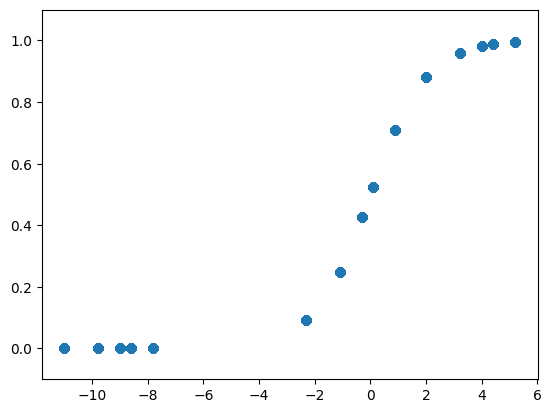

tensor(0.4548)


In [2]:
syn_year = torch.tensor([0, 1, 2]).repeat(10000)
syn_value = torch.tensor([0, 0.5, 0.6, 0.3, 0.8]).repeat(6000)

assert syn_year.shape == syn_value.shape

year_weights = torch.tensor([5, -8, 0.7])
parcel_are_weight = torch.tensor([4])
bias = -3

linear = bias + year_weights[syn_year] + parcel_are_weight * syn_value

probs_applied = torch.sigmoid(linear)
applied = torch.bernoulli(probs_applied)

print("type of applied", applied.dtype)

plt.scatter(linear, probs_applied)
plt.ylim(-0.1, 1.1)
plt.show()

syn_data = {
    "categorical": {"year": syn_year, "applied": applied},
    "continuous": {
        "value": syn_value,
    },
}

print(applied.mean())

syn_categorical_levels = {"year": torch.Tensor([0, 1, 2])}

Best normal std: 11.576767676767677, KL divergence: 0.43998274424068656


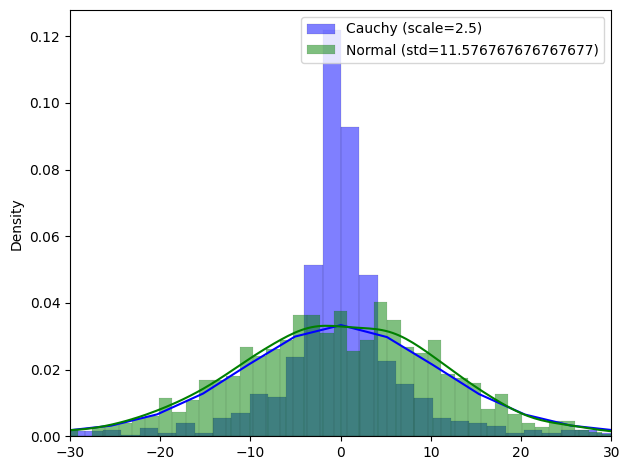

In [3]:
# see A WEAKLY INFORMATIVE DEFAULT PRIOR DISTRIBUTION FOR
# LOGISTIC AND OTHER REGRESSION MODELS
# B Y A NDREW G ELMAN , A LEKS JAKULIN , M ARIA G RAZIA
# P ITTAU AND Y U -S UNG S
# they recommed Cauchy with 2.5 scale for coefficient priors
# we'll approximate with normal


torch.manual_seed(123)

num_samples = 1000
cauchy_scale = 2.5

cauchy_samples = dist.Cauchy(0, cauchy_scale).sample([num_samples])
cauchy_hist, bin_edges = np.histogram(
    cauchy_samples.numpy(), bins=50, range=(-30, 30), density=True
)


normal_std_range = np.linspace(0.1, 30, 100)  # Range of standard deviations to test

min_divergence = float("inf")
best_normal_std = None

for normal_std in normal_std_range:
    # Sample from Normal distribution
    normal_samples = dist.Normal(0, normal_std).sample([num_samples])

    normal_hist, _ = np.histogram(
        normal_samples.numpy(), bins=50, range=(-30, 30), density=True
    )

    kl_divergence = entropy(cauchy_hist, normal_hist)

    if kl_divergence < min_divergence:
        min_divergence = kl_divergence
        best_normal_std = normal_std

print(f"Best normal std: {best_normal_std}, KL divergence: {min_divergence}")

normal_samples = dist.Normal(0, best_normal_std).sample([num_samples])


sns.histplot(
    cauchy_samples.numpy(),
    bins=500,
    kde=True,
    color="blue",
    stat="density",
    label=f"Cauchy (scale={cauchy_scale})",
)
sns.histplot(
    normal_samples.numpy(),
    bins=50,
    kde=True,
    color="green",
    stat="density",
    label=f"Normal (std={best_normal_std})",
)

plt.xlim(-30, 30)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
syn_mo_model = MissingnessOnlyModel(
    **syn_data, categorical_levels=syn_categorical_levels
)

with pyro.plate("samples", size=10, dim=-2):
    with pyro.poutine.trace() as tr:
        syn_mo_model(**syn_data)

print(tr.trace.nodes.keys())

print(tr.trace.nodes["bias_continuous_value_applied"]["value"].shape)

print(tr.trace.nodes["year"]["value"])

odict_keys(['data', 'year', 'value', 'bias_continuous_value_applied', 'weight_continuous_value_applied_', 'weights_categorical_year_applied', 'mean_outcome_prediction_applied', 'child_probs_applied', 'applied'])
torch.Size([10, 1])
tensor([0, 1, 2,  ..., 0, 1, 2])


[iteration 0001] loss: 85499.3906
[iteration 0050] loss: 76463.2422
[iteration 0100] loss: 73807.3438
[iteration 0150] loss: 72636.6016
[iteration 0200] loss: 72383.9766
[iteration 0250] loss: 72133.5547
[iteration 0300] loss: 72026.5391
[iteration 0350] loss: 71889.3672
[iteration 0400] loss: 71815.8906
[iteration 0450] loss: 71785.8203
[iteration 0500] loss: 71756.8125
[iteration 0550] loss: 71736.7734
[iteration 0600] loss: 71720.9297
[iteration 0650] loss: 71703.3516
[iteration 0700] loss: 71709.9844
[iteration 0750] loss: 71694.6641
[iteration 0800] loss: 71698.3672
[iteration 0850] loss: 71683.0703
[iteration 0900] loss: 71682.4453
[iteration 0950] loss: 71679.3438
[iteration 1000] loss: 71678.9062


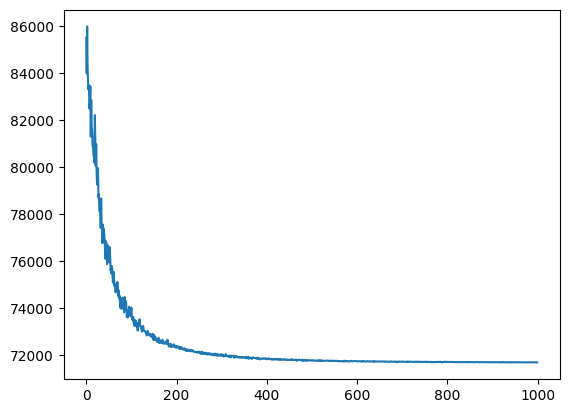

In [5]:
# smoke test inference

pyro.clear_param_store()
guide = run_svi_inference(
    syn_mo_model,
    n_steps=1000,
    lr=0.03,
    hide=["applied"],
    **syn_data,
)

# TODO check if hiding makes sense here

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


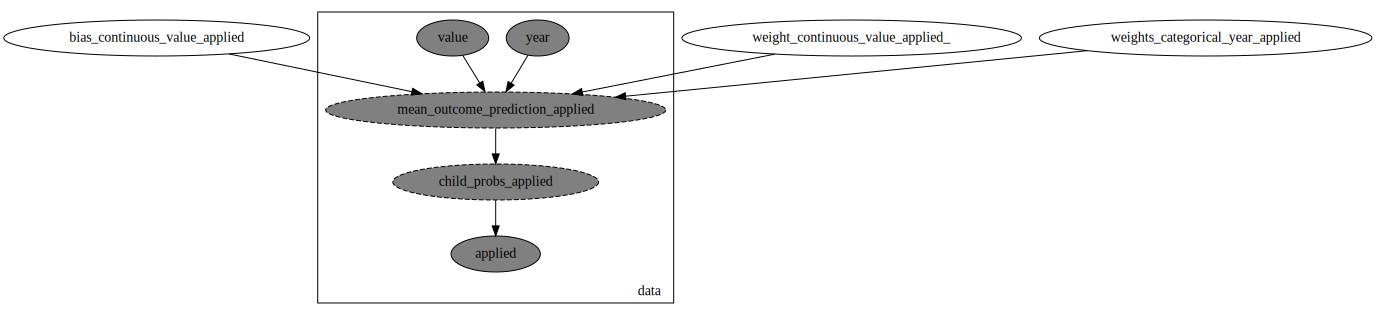

In [6]:
pyro.render_model(
    lambda: syn_mo_model(**syn_data),
    render_deterministic=True,
)

In [7]:
with MultiWorldCounterfactual() as mwc:
    with do(actions={"value": torch.tensor(1.0)}):
        with pyro.poutine.trace() as tr_do:
            syn_mo_model(**syn_data)


print(tr_do.trace.nodes["value"]["value"])

tensor([[[[[0.0000, 0.5000, 0.6000,  ..., 0.6000, 0.3000, 0.8000]]]],



        [[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]]])


In [8]:
predictive = Predictive(syn_mo_model, guide=guide, num_samples=1000)

syn_data_no_applied = copy.deepcopy(syn_data)
syn_data_no_applied["categorical"]["applied"] = None
samples = predictive(**syn_data_no_applied)
preds = torch.where(samples["applied"].mean(axis=0) > 0.5, 1.0, 0.0)

print(torch.where(samples["applied"].mean(axis=0) > 0.5, 1.0, 0.0).shape)

torch.Size([30000])


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

applied_np = applied.numpy()
preds_np = preds.numpy()

conf_matrix = confusion_matrix(applied_np, preds_np)
conf_matrix_percent = conf_matrix / conf_matrix.sum() * 100
conf_matrix_percent_df = pd.DataFrame(
    conf_matrix_percent,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"],
)

accuracy = accuracy_score(applied_np, preds_np)

print(f"Accuracy: {accuracy}")
display(conf_matrix_percent_df)

Accuracy: 0.8892333333333333


,Predicted 0,Predicted 1
Actual 0,48.423333,6.1
Actual 1,4.976667,40.5


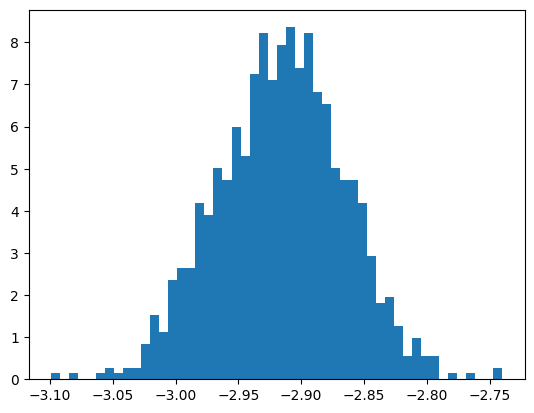

In [10]:
plt.hist(
    samples["bias_continuous_value_applied"].flatten().numpy(), bins=50, density=True
)
plt.show()

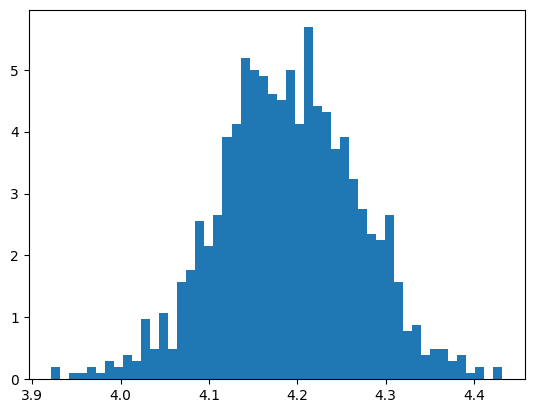

In [11]:
plt.hist(
    samples["weight_continuous_value_applied_"].flatten().numpy(), bins=50, density=True
)
plt.show()

In [12]:
# now the actual data

values_data_path = os.path.join(root, "data/minneapolis/processed/values_dataset.pt")

values_dataset_read = torch.load(values_data_path)


values_loader = DataLoader(
    values_dataset_read, batch_size=len(values_dataset_read), shuffle=True
)

data = next(iter(values_loader))

print(data["continuous"].keys())

dict_keys(['avg_value', 'value', 'avg_value_original', 'value_original'])


In [13]:
mo_model = MissingnessOnlyModel(
    **data, categorical_levels=values_dataset_read.categorical_levels
)

[iteration 0001] loss: 5652871.5000
[iteration 0050] loss: 4991231.0000
[iteration 0100] loss: 4880667.5000
[iteration 0150] loss: 4866453.5000
[iteration 0200] loss: 4859481.5000
[iteration 0250] loss: 4853028.5000
[iteration 0300] loss: 4852641.5000
[iteration 0350] loss: 4850610.0000
[iteration 0400] loss: 4850240.5000
[iteration 0450] loss: 4849399.5000
[iteration 0500] loss: 4848527.5000
[iteration 0550] loss: 4848618.5000
[iteration 0600] loss: 4848716.5000
[iteration 0650] loss: 4848132.5000
[iteration 0700] loss: 4848153.0000
[iteration 0750] loss: 4847964.0000
[iteration 0800] loss: 4847907.0000
[iteration 0850] loss: 4847900.5000
[iteration 0900] loss: 4847763.0000
[iteration 0950] loss: 4847794.5000
[iteration 1000] loss: 4847836.0000


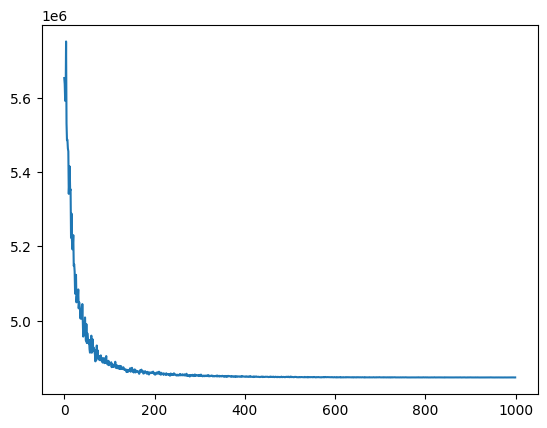

In [14]:
pyro.clear_param_store()
guide = run_svi_inference(
    mo_model,
    n_steps=1000,
    lr=0.03,
    hide=["applied"],
    **data,
)

In [15]:
predictive = Predictive(mo_model, guide=guide, num_samples=100)

data_no_applied = copy.deepcopy(data)
data_no_applied["categorical"]["applied"] = None
samples = predictive(**data_no_applied)
preds = torch.where(samples["applied"].mean(axis=0) > 0.5, 1.0, 0.0)

print(torch.where(samples["applied"].mean(axis=0) > 0.5, 1.0, 0.0).shape)

torch.Size([1296771])


In [16]:
applied_np = data["categorical"]["applied"].numpy()
preds_np = preds.numpy()

conf_matrix = confusion_matrix(applied_np, preds_np)
conf_matrix_percent = conf_matrix / conf_matrix.sum() * 100
conf_matrix_percent_df = pd.DataFrame(
    conf_matrix_percent,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"],
)

accuracy = accuracy_score(applied_np, preds_np)

print(f"Accuracy: {accuracy}")
display(conf_matrix_percent_df)

Accuracy: 0.9976194717494453


,Predicted 0,Predicted 1
Actual 0,99.761947,0.0
Actual 1,0.238053,0.0
